# A Multiagent transportation system - Paper edition

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_transportation_fr.ipynb](mas_transportation_fr.ipynb) qui donnait les bases de la construction d'un système de co-voiturage à l'aide des agents.
Nous vous montrons ici le développement de ce système de covoiturage avec différents comportements de passagers et une gestion différente de l'information entre passagers et conducteurs.

In [1]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor
import copy
import pandas as pd

## Des stratégies différentes pour les passagers
Dans le document précédent, nous avions détaillé une stratégie basique consistant à ne prendre en compte que les conducteurs présents sur la position du passager pour évaluer une prise en charge et prendre une décision. Cette stratégie est basée sur le comportement d'un autostoppeur et nous nommerons cette approche par l'approche **naive**.
Nous allons maitenant détailler une autre approche nommé **ReTAG** pour **Realtime Trip Avaibility graph** aproach (approche basée sur un graphe des trajets disponibles en temps réel).

Pour plus de clarté nous allons créer une abstract classe *RiderAgent(Agent)* pour les passagers et chaque stratégie de passager héritera des spécificités de cette classe.

In [2]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
    
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr      
            
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

On récupère le code de notre passager naif de la précédente feuille, on pourra lui ajouter des paramètres comme *travel_time* et *wt*(waiting time) en fonction de ce que l'on voudra étudier.

In [3]:
class NaiveRiderAgent(RiderAgent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id, v_dep, v_arr)
        self.travel_time = 0 #temps total du trajet, s'incrémente à chaque pas de simulation
        self.wt = 0 #temps d'attente total lors du trajet, s'incrémente à chaque fois que le véhicule ne bouge pas
        
    def to_string(self):
        print("I am", self.__class__.__name__ ,self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
                 
            
    def update(self):
        cur_node = self.v_r
        caragent = [agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent" and agent.v_r == self.v_r and len(agent.trip)>1)]
        if len(caragent) > 0:
            best_driver = None
            for ad in caragent:
                next_node = ad.trip[1]
                contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=next_node, target=self.v_arr)
                if contrib > 0:
                    best_driver = ad
                    break
            
            if best_driver != None :
                new_node = best_driver.trip[1]
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver.unique_id)
                if new_node == self.v_arr:
                    if sma.verbose == True:
                        print("Rider n°",self.unique_id,"arrived")
                    self.is_alive = False
                    return    
            else : 
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
                self.wt+=1
               
        else:  
            if sma.verbose == True:
                print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
            self.wt+=1
        
        self.v_r = new_node
        self.travel_time += 1
        
    def decide(self):
        pass

In [4]:
r = NaiveRiderAgent(1,1,6)

In [5]:
r.to_string()

I am NaiveRiderAgent 1 - dep: 1 , arr: 6


 ### Vers la prise en compte des transitions possibles
 Quand nous prenons les transports publics pour rejoindre une destination, il est rare qu'il faille utiliser un seul et unique mode de transport ou une seule et même ligne. Ainsi pour aller de Lille à Lyon, je devrai certainement prendre un train jusque Paris, puis prendre un métro pour changer de gare pour enfin prendre un train vers Lyon. Ces changements sont appelés des transitions ou des tranferts. Dans notre modèle de covoiturage, une transition ou un transfert représente le fait de descendre d'un véhicule pour en emprunter un autre, autrement dit, elle représente l'intersection des itinéraires de deux (ou plus) conducteurs. Cette intersection implique, si elle respecte les contraintes (temps, capacité...), que le trajet du conducteur est potentiellement disponible pour le passager. Ainsi, on peut élaborer une liste des trajets disponibles et de leurs lieux d'intersection, cette liste peut être matérialisée par un graphe dit de transition **G_ts**.
 
Seulement il faut alors, pour chaque noeud potentiellement disponible, demander à chaque conducteur si ce dernier passe par ce noeud et ce pour chaque agent passager... Ce processus peut vite devenir très lourd computationellement. L'astuce est donc de créer, à chaque début de pas de simulation, une table de correspondance (look up table) indiquant, pour chaque noeud du graphe de réseau routier, les conducteurs passants par ce noeud et leur distance par rapport à ce noeud. Les passagers pourront donc disposer de l'information des conducteurs passant par un noeud avec un unique appel. Nous avons donc créé un agent **Service de transport (TSA)**, il sera responsable de la collecte des données auprès des conducteurs en début de pas de simulation et transmettra ces données aux passagers le demandant. 

Cet agent construit un dictionnaire prenant en clé chaque noeud du système et en valeur, les conducteurs, leur distance par rapport à ce noeud - c'est à dire le nombre restant de pas de simulation avant de rejoindre le noeud - et enfin le sous-trajet du conducteur de ce noeud à la destination.

In [6]:
class TransportServiceAgent(Agent):
    #tsa
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.drivers_nodes_tracker = dict()
    
     
    def get_rider_matched_drivers(self, node):
        
        return self.drivers_nodes_tracker[node]
    
    def update(self):
        drivers = [agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")]
        
        #pour tous les noeuds du graph de route
        for node in list(sma.graph.nodes()):
            #on initialise l'entrée du dictionnaire
            self.drivers_nodes_tracker[node] = list()
        
        #puis pour chaque clé
        for key in list(self.drivers_nodes_tracker.keys()):
            #et chaque conducteur
            for driver in drivers : 
                #si le noeud est présent dans le trajet du conducteur
                if key in driver.trip:
                    #on récupère l'indice de ce noeud
                    m_idx = driver.trip.index(key)
                    #et le sous trajet
                    sub_trip = driver.trip[m_idx:]
                    #on verifie que le noeud de transition n'est pas l'arrive du conducteur
                    if len(sub_trip) > 1:
                        #puis on ajoute la valeur au dictionnaire
                        self.drivers_nodes_tracker[key].append((driver.unique_id, driver.trip[m_idx:], m_idx))
        
    def decide(self):
        pass

Chaque passager peut donc effectuer une requête à l'agent TSA sur les conducteurs passant par un noeud, à l'instant ou dans le futur et ce afin de construire son graphe des trajets et transitions disponibles.
Un passager peut ensuite, à l'aide d'une heuristique et d'une pondération des arêtes de ce graphe, choisir un chemin en temps réel. C'est ce processus que l'on détaille dans la classe de passager ci dessous :

In [7]:
class RetagRiderAgent(RiderAgent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id, v_dep, v_arr)
        #initialisation du graphe de transition
        self.G_ts = None
        
        #initilisation du tracker de conducteur, celui ci permet de s'assurer que ne l'on prenne pas
        #en compte un conducteur déja traité afin d'éviter les boucles infinies
        self.trace_drivers = []
        
        #initialisation des données qui vont être récoltées en vu d'être analysées
        self.wt = 0 #temps d'attente
        self.nb_moves = 0 #nombre de mouvement au total
        self.nb_transition = 0 #nombre de transitions TODO
        self.compute_time = None #temps d'éxécution
        self.travel_time = 0 #temps de trajet
        
        
    def to_string(self):
        print("I am", self.__class__.__name__ ,self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
        
    def generate_transition_graph_v2(self):
        '''Fonction permettant la création du graphe de transition'''
        #On initialise le graphe avec le noeud de départ
        self.G_ts = nx.MultiDiGraph()
        self.G_ts.add_node(self.v_r, distance=0)
        
        #pour chaque véhicule passant sur la case du passager, on va identifier 
        #tous les noeuds accessibles à partir de ces derniers, 
        #récursivement grâce à la méthode create_nodes_of_ad()
        for ad in tsa.get_rider_matched_drivers(self.v_r):
            d_time_left = ad[2] #distance entre le conducteur d et le noeud
            r_time_left = 0 #distance du passager, 0 car il est sur place
            #si la contrainte de temps est satisfaite (inutile car c'est toujours le cas?)
            if d_time_left >= r_time_left :
                self.trace_drivers.append(ad[0])
                distance = d_time_left
                #on vérifie si il y a d'autres conducteurs disponibles et dont l'on pourrait partager le trajet
                node = self.create_nodes_of_ad(ad, distance)
                
                #si oui, on ajoute le noeud retourné par la méthode create_nodes_of_ad()
                #ce noeud sera préalablement lié à un sous graphe des trajets disponibles à partir du conducteur
                #il permettra donc de fusionner le noeud du passager et les noeuds rendus disponible par ce conducteur
                if node != None:
                    contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=node, target=self.v_arr)
                    delay = d_time_left
                    self.G_ts.add_edge(self.v_r, node, d=ad, contrib=contrib, delay=delay)
        
    def create_nodes_of_ad(self, ad, prev_distance):
        '''Fonction récursive permettant de parcourir les noeuds disponibles à partir
        du trajet d'un conducteur ad.
        - si l'on trouve un noeuds de transition on passe à un autre conducteur 
        - sinon on identifie le noeuds le plus interessant à garder'''
        
        #on commence par récuperer le trajet du conducteur et la distance du noeud précédent 
        #puis on initialise quelques flags variables
        trip = ad[1][1:]
        first_node = None
        last_created_node = None
        distance = prev_distance + ad[2] + 1

        #pour chaque noeuds du trajet du véhicule
        for i in range(len(trip)):
            node = trip[i]
            distance += 1
            #si il existe une transition avec d'autres conducteurs
            if len(tsa.get_rider_matched_drivers(node)) > 1:
                other_Ad = [ads for ads in tsa.get_rider_matched_drivers(node) if ads[0]!=ad[0]]
                #pour chacun de ces autres conducteurs
                for d in other_Ad:
                    d_time_left = d[2]
                    #si la transition est faisable en temps/distance
                    if d_time_left >= distance and d[0] not in self.trace_drivers:
                        self.trace_drivers.append(d[0])
                        new_node = self.create_nodes_of_ad(d, distance)
                        if new_node != None:
                            
                        #si le noeud n'existe pas encore dans le graphe, on l'ajoute
                            if not (self.G_ts.has_node(node)):
                                    self.G_ts.add_node(node, distance=distance)
                            #si c'est le premier noeud qu'on ajoute pour cette transition, on le garde
                            #c'est sur ce noeud qu'on connectera le graphe et les noeuds nouvellement créés
                            if first_node == None:
                                first_node = node

                            #sinon, on lie simplement le noeud au noeud précédent
                            else :
                                contrib = nx.shortest_path_length(sma.graph, source=last_created_node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=node, target=self.v_arr)
                                delay = 0
                                self.G_ts.add_edge(last_created_node, node, d=ad, contrib=contrib, delay=delay)

                            #on met à jour le dernier noeud créé afin de pouvoir y lier le prochain si nécessaire
                            last_created_node = node

                            #on va par la suite vérifier récursivement si pour ce conducteur, 
                            #il n'existe pas d'autres transitions ou noeuds intéressants
                            #new_node = self.create_nodes_of_ad(d, distance)

                            contrib = nx.shortest_path_length(sma.graph, source=node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
                            delay = d_time_left - distance
                            self.G_ts.add_edge(node, new_node, d=d, contrib=contrib, delay=delay)

        #si l'on n'a trouvé aucune transition dans le trip du conducteur
        #on va tout de même regarder si il n'y a pas de noeuds intéressants
        #WARNING : ce processus ne fonctionne que si les conducteurs vont au plus court chemin sans détour
        if first_node == None:
            
            full_trip = ad[1]
            #on part du dernier noeud et on recupère sa contribution
            last_node = full_trip[-1]
            source_node = full_trip[0]
            contrib = nx.shortest_path_length(sma.graph, source=source_node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=last_node, target=self.v_arr)
            
            #si la taille du voyage est inférieur ou égal à 2
            #ça veut dire qu'il ne reste au condcuteur qu'un seul noeud à parcourir avant sa destination
            #donc on ajoute ce noeud au graphe
            
            if (len(full_trip) <= 2) & (contrib >= 0):
                    first_node = last_node
                    
            #sinon, on va vouloir identifier le meilleur noeud a prendre dans le voyage
            #cependant, calculer la contribution de chaque noeud c'est faire une différence de chemin
            #le plus court pour chaque noeuds = grande compléxité
            #alors on utilise un petit stratagème :
            else :
                #on va identifier trois cas :
                
                
                #une contribution négative du dernier noeud
                #intuition : il peut y avoir un noeud avec une contribution positive dans le voyage 
                #du conducteur car size(trip)>2 et contrib(source)=0
                if contrib < 0:
                    #on va ici chercher si il existe une contribution non négative dans le voyage du conducteur
                    best_node_index = floor(len(full_trip[:contrib])/2)
                    #si cette contribution est identifiée sur le premier noeud, alors il n'y a aucune contribution +
                    if best_node_index != 0:
                        first_node = full_trip[best_node_index]
                        #first_node = full_trip[-1]
                        
                    #sinon c'est qu'il y a un bien une contribution +, et donc on prend ce noeud
                    #else :
                        
                        
                #une contribution nule du dernier noeud
                #intuition : il y a un noeud avec une contribution positive dans le voyage 
                #du conducteur car size(trip)>2 et contrib(source)=0
                if contrib == 0 :
                    best_node_index = floor(len(full_trip)/2)
                    if best_node_index != 0:
                        first_node = full_trip[best_node_index]
                    #print("=")

                #une contribution positive du dernier noeud
                #il faut pouvoir trouver le meilleur noeud
                if contrib > 0 :
                    tmp = full_trip[contrib:] 
                    best_node_index = floor(len(tmp)/2)
                    first_node = tmp[best_node_index]
                    #print(">")
                    
            
            if first_node != None:
                #si ce noeud n'éxiste pas on le crée 
                if not (self.G_ts.has_node(first_node)):
                    distance = prev_distance + ad[2] + full_trip.index(first_node)
                    self.G_ts.add_node(first_node, distance=distance)
        
        #point crucial de la recursion : on retourne toujours le premier noeud créé dans le module du conducteur
        #il servira à se connecter au reste du graphe
        return first_node
        
    
    
    def best_driver_contrib_and_wait(self):
        '''on parcourt tous les chemins possibles du graphe et on identifie le plus intéressant :
        - en priorisant les trajets permettant de rejoindre la destination, à discuter!!!!!
        - si il n'y en a pas pour l'instant on prend le meilleur de tous
        on renvoie le premier conducteur du meilleur chemin'''
        
        scores_paths = dict()
        cur_node = self.v_r
        #si il y a un ou plusieurs chemins permettant de rejoindre l'arrivée, on ne prends en compte que ceux-la
        #PAS DE RISQUE, on pourra potentiellement changer ça, autre comportement: risque ou pas risque
        if self.G_ts.has_node(self.v_arr):
            paths = nx.all_simple_paths(self.G_ts, self.v_r, self.v_arr, cutoff=None)
            
        #sinon on prend la meilleure solution actuelle
        else :
            other_nodes = [node for node in list(self.G_ts.nodes()) if node != cur_node]
            paths = nx.all_simple_paths(self.G_ts, source=cur_node, target=other_nodes)

        #heuristique : suivre le chemin qui rapporte le plus de cases le plus rapidement possible
        for path in paths :
            id_d = None
            score_path = 0
            #print(path)
            for i in range(len(path)):

                if i+1<len(path):
                    data = self.G_ts.get_edge_data(path[i], path[i+1])
                    #print(data)

                    #si il y a plusieurs arretes menants au meme noeuds

                    best_score = None
                    #on est dans un multigraph, donc on prends la meilleur edge
                    for j in range(len(data)):
                        cur_score = data[j]['contrib'] - data[j]['delay'] #pareil ici, a discuter
                        if best_score == None or best_score < cur_score:
                            best_score = cur_score
                            if i==0 :
                                id_d = data[j]['d'][0]

                    score_path += best_score                   

                else :
                    break

            scores_paths[id_d]=score_path
        #si il y a une solution positive alors    
        if len(scores_paths.values()) >0 :
            #on récupère les meilleurs conducteurs associés (ex equo)
            bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
            #on mélange cette liste
            random.shuffle(bests_d)
            
            #puis on regarde si il y en a un qui est sur le noeud courant
            for d in tsa.get_rider_matched_drivers(cur_node):
                if d[0] in bests_d and d[2] == 0:
                    return(d)
                
        #si il n'y a aucune solution on retourne None
        return None

###### Strategie naive utilisant TSA #####    
#     def naive_strategy(self):
#         for ad in tsa.get_rider_matched_drivers(self.v_r):
#             next_node = ad[1][1]
#             contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=next_node, target=self.v_arr)
#             if contrib > 0:
#                 return ad
#         return None
######           
            
    def update(self):
        
        #timer pour evaluer le temps de réponse d'un agent
        start = timer()
        self.trace_drivers = []
        
        self.generate_transition_graph_v2()
        cur_node = self.v_r
        
        #il est necessaire qu'un conducteur soit présent sur le noeud courant, sinon de toute façon,
        #le passager ne pourra pas bouger ce tour ci, il est donc inutile de calculer quelquechose
        
        if len(tsa.get_rider_matched_drivers(cur_node)) > 0 and len([driver for driver in tsa.get_rider_matched_drivers(cur_node) if driver[2]==0])>0:
            
            #on cherche si parmis les conducteurs disponibles il existe un contribuant
            best_driver = self.best_driver_contrib_and_wait()
            
            #si oui on récupère le meilleur et le prochain noeud du passager sera le prochain noeud du conducteur
            if best_driver != None :
                
                new_node = best_driver[1][1]
                self.nb_moves += 1
                if sma.verbose == True:
                    
                    print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver)
                
                if new_node == self.v_arr:
                    if sma.verbose == True:
                        print("Rider n°",self.unique_id,"arrived with a waiting time of",self.wt,"ticks")
                    end = timer()
                    self.compute_time = end - start
                    self.is_alive = False
                    return
            
            else : 
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
                self.wt += 1
            
            
        else:
            if sma.verbose == True:
                print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
            self.wt += 1
        
        self.v_r = new_node
        end = timer()
        self.compute_time = end - start
        self.travel_time+=1
        
    def decide(self):
        pass

In [8]:
b = RetagRiderAgent(1,2,3)

In [9]:
b.to_string()

I am RetagRiderAgent 1 - dep: 2 , arr: 3


on récupère les fonctions utiles à la création d'un graphe de réseau de route (feuille précédente) :

In [10]:
#fonction permettant de générer un graphe en grille aléatoire avec perturbation d'arête 
#n indique le nombre de noeuds au carré
#la variable coef suppr détermine le coefficient de suppression des arêtes
#la variable show indique si il faut afficher le graphe ou non
def generate_2D_graph(n, coef_suppr=False, show=False):
    graph = nx.grid_2d_graph(n, n)  # n x n grid

    if coef_suppr != False:
        nb_suppr = int(len(list(graph.nodes))*coef_suppr)

        random_edge(graph, nb_suppr, delete=True)
    
    pos = nx.spring_layout(graph, iterations=100)

    
    graph.remove_nodes_from(list(nx.isolates(graph)))
    graph = graph.to_directed()
    
    if show:
        nx.draw(graph, pos, node_color='b', node_size=20, with_labels=False)
        plt.title("Road network")
        plt.show()
        
    return graph

#ajoute ou supprime un nombre d'arêtes dans un graphe
def random_edge(graph, nb_edges, delete=True):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    if delete:
        # delete chosen edge
        chosen_edges = random.sample(edges, nb_edges)
        for edge in chosen_edges :
            graph.remove_edge(edge[0], edge[1])
    # add new edge
    else:
        chosen_nonedges = random.sample(nonedges, nb_edges)
        for non_edge in chosen_nonedges:
            graph.add_edge(non_edge[0], non_edge[1])

    return graph

puis on récupère notre agent conducteur :

In [11]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.v_arr = trip[-1]
        self.v_r = trip[0]
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
        
    def update(self) :
        pass
    
    def decide(self) :
        if len(self.trip)>0:
            a = self.trip.pop(0)
            self.v_r = a
        else :
            self.is_alive = False
            if sma.verbose == True:
                print("Driver",self.unique_id,"arrived")
            

On recuperera ensuite notre agent générateur **TGA** et notre classe système multi agent en les modifants légérement pour qu'ils puissent accepter deux types d'agents.

In [12]:
import random
class SMA:
    def __init__(self, verbose=False):
        self.tick=0
        self.resetTicks()
        self.agentList = []
        self.graph = None
        self.verbose = verbose
        #déclaration variable de la récup des données
        self.data = {}
        self.total_number_drivers = 0
        self.total_number_riders = 0

    def resetTicks(self):
        tick=0
          
    def setRoadGraph(self,graph):
        self.graph = graph
        
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        #initialisation données
        self.data["travel_time_r"] = []
        self.data["waiting_time_r"] = []
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentList :
            ag.update()
            ag.decide()
            
        for ag in self.agentList:
            if ag.is_alive == False:
                #si c'est un agent passager
                if "RiderAgent" in ag.__class__.__name__:
                    #on recupère ses données
                    self.data["travel_time_r"].append(ag.travel_time)
                    self.data["waiting_time_r"].append(ag.wt)
                self.agentList.remove(ag)
                
        if self.verbose == True:      
            print("tick "+str(self.tick)+" ended")

In [13]:
class GeneratorAgent(Agent):
    def __init__(self, current_id, max_drivers, max_riders, rider_type, seed=None):
        super().__init__(current_id)
        self.n_id = current_id+1
        self.seed = seed
        if self.seed!=None:
            random.seed(seed)
        
        self.rider_type = rider_type
        self.max_drivers = max_drivers
        self.max_riders = max_riders
        
    #gestion des id uniques    
    def next_id(self):
        self.n_id += 1
        return self.n_id

    

    #génere les agents conducteurs
    def driverAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        trip = nx.shortest_path(sma.graph, n1, n2)
        d = DriverAgent(self.next_id(), trip)
        sma.addAgent(d)
        sma.total_number_drivers += 1
        
        

    #génere les agents passagers
    def riderAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        #en fonction du type de conducteur
        if self.rider_type == "naive":
            r = NaiveRiderAgent(self.next_id(), n1, n2)
        elif self.rider_type == "retag":
            r = RetagRiderAgent(self.next_id(), n1, n2)
        else :
            raise NameError('Select either naive or retag')
        sma.addAgent(r)
        sma.total_number_riders += 1
        
    def update(self):
        
        #on récupère le nombre courant d'agents dans le système
        nb_drivers = len([agent for agent in sma.agentList if ("DriverAgent" in agent.__class__.__name__)])
        nb_riders = len([agent for agent in sma.agentList if ("RiderAgent" in agent.__class__.__name__)])
        
        #puis on complète par rapport au nombre maximal fixé
        driver_difference = self.max_drivers - nb_drivers
        rider_difference = self.max_riders - nb_riders
        
        for i in range(driver_difference):
            self.driverAgentGenerator()
        if sma.verbose == True:
            print(driver_difference,"drivers generated.")
            
        for i in range(rider_difference):
            self.riderAgentGenerator()
        if sma.verbose == True:
            print(rider_difference,"riders generated.") 
        
    def decide(self):
        pass
        

### Expérimentations et analyses
Nous avons développé deux types de comportements : un comportement basique correspondant à un autostoppeur et un comportement plus complexe correspondant à un utilisateur d'un plateforme de covoiturage dynamique et temps réel dans une forme simple (pas de préférences, pas de capacité des véhicules...).

Le but du comportement basique est avant tout de se procurer une base afin d'évaluer l'apport d'une stratégie plus complexe. Ainsi, en comparant divers indicateurs (temps de trajet, d'attente ou nombre de requêtes satisfaites...) en fonction de différentes situations, c'est à dire en faisant varier les paramètres de base de la création du système, on aura un aspect de l'impact d'une stratégie.

Relançons notre expérience qui consiste à faire évoluer le nombre de conducteurs disponibles. Nous pourrons ensuite comparer les résultats avec les deux stratégies/comportements.

In [14]:
SIZE_MAP = 10 #graphe en grille donc NOMBRE DE NOEUDS = SIZE_MAP * SIZE_MAP
MAX_NB_DRIVERS = np.arange(5,100,10)
MAX_NB_RIDERS = 200
NB_RUN = 200
SEED = 10

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


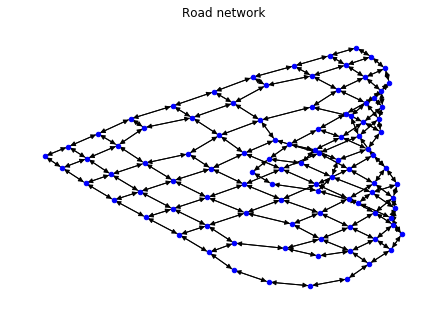

In [15]:
#temps moyen de trajet
mean_travel_time_per_d_naive = []
mean_travel_time_per_d_retag = []

#proportion de requêtes desservies
provided_requests_percent_naive = []
provided_requests_percent_retag = []

#temps d'attente moyen
mean_waiting_time_per_d_naive = []
mean_waiting_time_per_d_retag = []



graph = generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True)


for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    tsa = TransportServiceAgent(0)
    tga = GeneratorAgent(1,nb_d,MAX_NB_RIDERS, "naive",seed=SEED)
    sma.addAgent(tsa)
    sma.addAgent(tga)
    sma.run(NB_RUN)
    
    #on récupère les données
    mean_travel_time_per_d_naive.append(np.mean(sma.data["travel_time_r"]))
    #print("Finished number for naive: ",len(sma.data["mean_travel_time_r"]),"of",sma.total_number_riders,
    #      "-", (len(sma.data["mean_travel_time_r"])/(sma.total_number_riders)) * 100 )  
    provided_requests_percent_naive.append((len(sma.data["travel_time_r"])/(sma.total_number_riders)) * 100)
    mean_waiting_time_per_d_naive.append(np.mean(sma.data["waiting_time_r"]))

for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    tsa = TransportServiceAgent(0)
    tga = GeneratorAgent(1,nb_d,MAX_NB_RIDERS, "retag",seed=SEED)
    sma.addAgent(tsa)
    sma.addAgent(tga)
    sma.run(NB_RUN)
    mean_travel_time_per_d_retag.append(np.mean(sma.data["travel_time_r"]))
    #print("Finished number for ReTAG: ",len(sma.data["mean_travel_time_r"]),"of",sma.total_number_riders,
    #      "-", (len(sma.data["mean_travel_time_r"])/(sma.total_number_riders)) * 100 )
    provided_requests_percent_retag.append((len(sma.data["travel_time_r"])/(sma.total_number_riders)) * 100)
    mean_waiting_time_per_d_retag.append(np.mean(sma.data["waiting_time_r"]))


On peut donc s'intérésser au temps moyen necessaire aux agents pour rejoindre leur objectif.

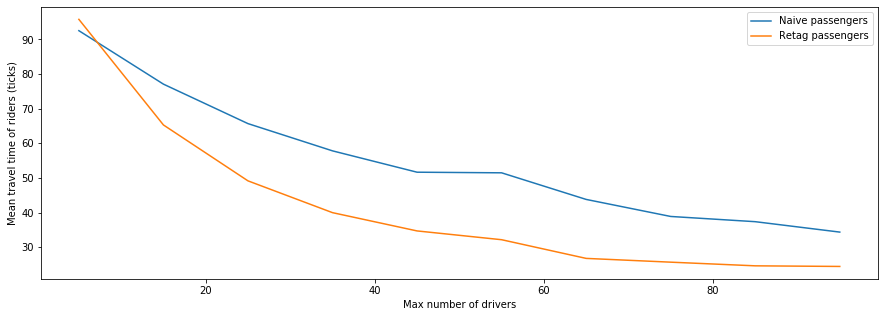

In [16]:
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d_naive,label = 'Naive passengers')
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d_retag,label = 'Retag passengers')


plt.xlabel('Max number of drivers')
plt.ylabel("Mean travel time of riders (ticks)")
plt.legend()
plt.show()

On s'aperçoit ici que les passagers suivant l'approche ReTAG (en orange) mettent moins de temps en moyenne à rejoindre leur objectif que les conducteurs de l'approche naïve. En effet, les passagers ReTAG disposent de bien plus d'informations que les autres, leur permettant d'éviter d'être coincé sur un noeud et de faire des détours pour être sûr de bien arriver à destination. Cet avantage se ressent sur les résultats.


Cepandant on prend en compte ici uniquement les requêtes qui ont abouties, il faut donc disposer de l'information du pourcentage de requêtes abouties en fonction du nombre de conducteurs et de la stratégie afin de pouvoir écarter un biais de différence de génération. C'est aussi un indicateur important de la littérature afin d'évaluer la robustesse d'une stratégie, enfin cet indicateur sera précieux lors de l'ajout de la limitation de capacité des conducteurs.

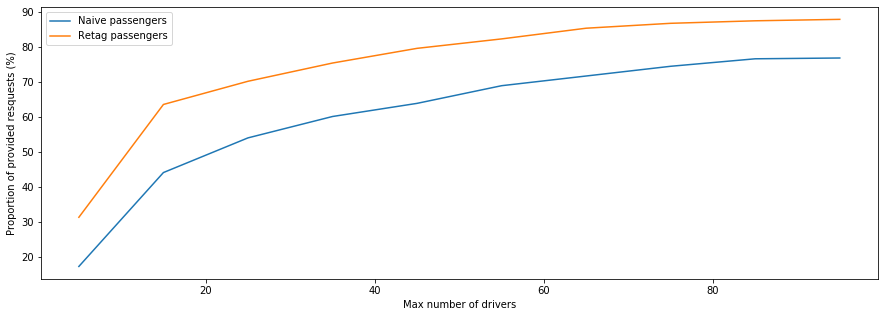

In [17]:
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,provided_requests_percent_naive,label = 'Naive passengers')
plt.plot(MAX_NB_DRIVERS,provided_requests_percent_retag,label = 'Retag passengers')


plt.xlabel('Max number of drivers')
plt.ylabel("Proportion of provided resquests (%)")
plt.legend()
plt.show()

On remarque que la stratégie ReTAG permet à un pourcentage plus grand de passagers d'atteindre leurs destinations. En effet, l'un des buts premiers d'un passager ReTAG est de prioriser les conducteurs qui l'amèneront à destination sans risque (parfois au dépend de l'optimisation du temps de trajet et d'attente).
Tandis que les passagers naifs n'ont pas connaissance du reste de leur environnement, ils avancent donc à l'aveugle et peuvent rester coincé sur un noeud peu déservi par exemple.

On peut aussi s'intéresser au temps d'attente total moyen des passagers, c'est encore une fois un bon indicateur de performance d'une stratégie.

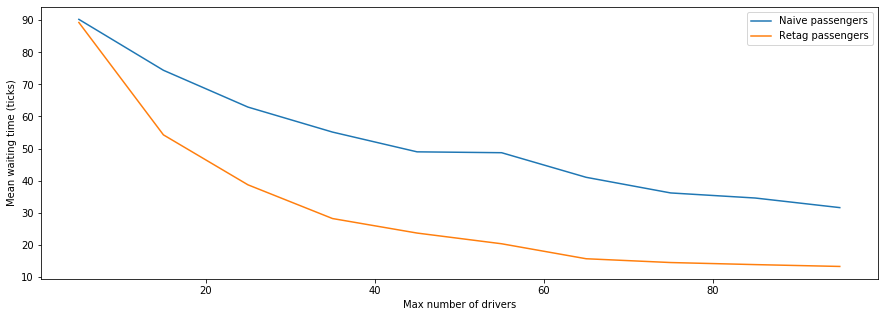

In [18]:
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_waiting_time_per_d_naive,label = 'Naive passengers')
plt.plot(MAX_NB_DRIVERS,mean_waiting_time_per_d_retag,label = 'Retag passengers')


plt.xlabel('Max number of drivers')
plt.ylabel("Mean waiting time (ticks)")
plt.legend()
plt.show()

On remarque que les passagers suivant la méthode ReTAG attendent moins longtemps que les passagers naïfs. Nous optimisons le temps d'attente dans l'heuristique décisionelle de ReTAG, ainsi le passager cherche à reduire au possible ce temps d'attente, ce qui explique ces résultats.

## EN APPARTE
### PROBLEME A REGLER :
Pour le moment, si l'on mets énormément de conducteurs pour un tout petit espace :

In [24]:
SIZE_MAP = 4 #graphe en grille donc NOMBRE DE NOEUDS = SIZE_MAP * SIZE_MAP
MAX_NB_DRIVERS = np.arange(5,500,50)
MAX_NB_RIDERS = 200
NB_RUN = 200

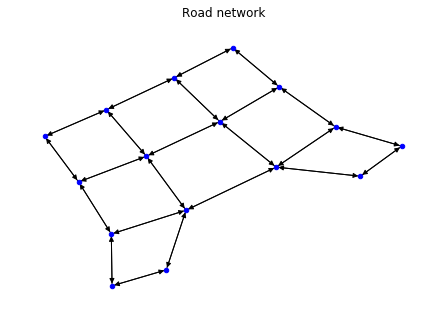

In [25]:
#temps moyen de trajet
mean_travel_time_per_d_naive = []
mean_travel_time_per_d_retag = []

#proportion de requete desservies
provided_requests_percent_naive = []
provided_requests_percent_retag = []

#temps d'attente moyen
mean_waiting_time_per_d_naive = []
mean_waiting_time_per_d_retag = []



graph = generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True)


for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    tsa = TransportServiceAgent(0)
    tga = GeneratorAgent(1,nb_d,MAX_NB_RIDERS, "naive",seed=SEED)
    sma.addAgent(tsa)
    sma.addAgent(tga)
    sma.run(NB_RUN)
    
    #on récupère les données
    mean_travel_time_per_d_naive.append(np.mean(sma.data["travel_time_r"]))
    provided_requests_percent_naive.append((len(sma.data["travel_time_r"])/(sma.total_number_riders)) * 100)
    mean_waiting_time_per_d_naive.append(np.mean(sma.data["waiting_time_r"]))

for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    tsa = TransportServiceAgent(0)
    tga = GeneratorAgent(1,nb_d,MAX_NB_RIDERS, "retag",seed=SEED)
    sma.addAgent(tsa)
    sma.addAgent(tga)
    sma.run(NB_RUN)
    mean_travel_time_per_d_retag.append(np.mean(sma.data["travel_time_r"]))
    provided_requests_percent_retag.append((len(sma.data["travel_time_r"])/(sma.total_number_riders)) * 100)
    mean_waiting_time_per_d_retag.append(np.mean(sma.data["waiting_time_r"]))

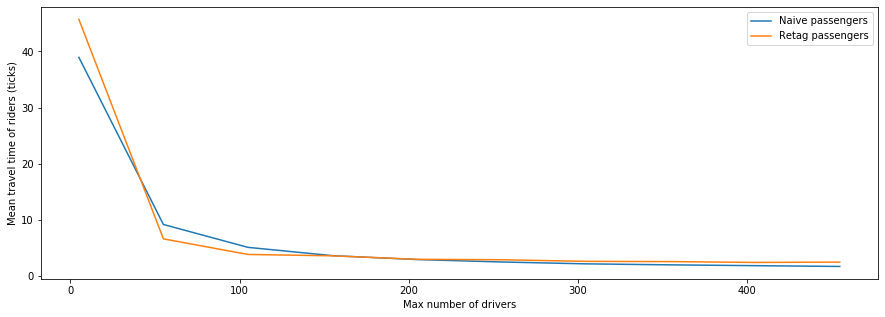

In [26]:
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d_naive,label = 'Naive passengers')
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d_retag,label = 'Retag passengers')


plt.xlabel('Max number of drivers')
plt.ylabel("Mean travel time of riders (ticks)")
plt.legend()
plt.show()

Les courbes tendent vers 0 car de nombreux conducteurs, beaucoup d'offre donc c'est tout à fait normal.

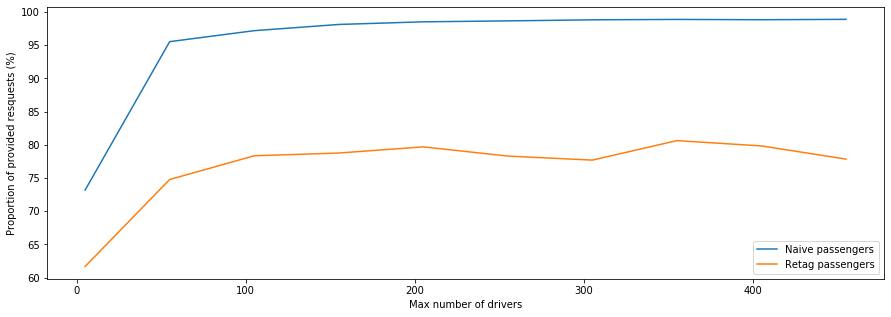

In [27]:
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,provided_requests_percent_naive,label = 'Naive passengers')
plt.plot(MAX_NB_DRIVERS,provided_requests_percent_retag,label = 'Retag passengers')


plt.xlabel('Max number of drivers')
plt.ylabel("Proportion of provided resquests (%)")
plt.legend()
plt.show()

Nous avons un problème, parfois la courbe ReTAG est bien en dessous de la courbe Naive (elle tend vers 75% alors qu'elle devrait tendre vers 100% comme la courbe naive), hors la courbe ReTAG devrait se superposer ou dépasser la courbe naive, c'est sûrement du au fait qu'il y a de nombreux conducteurs et il doit y avoir un problème de boucle infinie ou d'ex-equo qui empêche certains passagers ReTAG d'atteindre leur but. Il faut que je règle ça.
Les deux courbes doivent tendrent vers 100%.

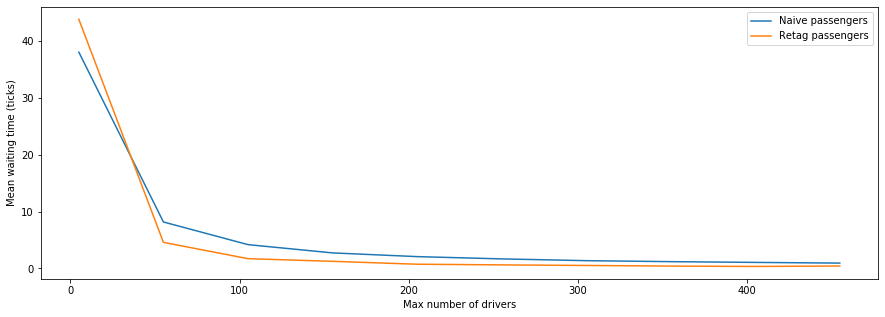

In [28]:
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_waiting_time_per_d_naive,label = 'Naive passengers')
plt.plot(MAX_NB_DRIVERS,mean_waiting_time_per_d_retag,label = 'Retag passengers')


plt.xlabel('Max number of drivers')
plt.ylabel("Mean waiting time (ticks)")
plt.legend()
plt.show()

Les courbes tendent vers 0, c'est normal car on a des véhicules partout et qui vont dans tous les sens, pas ou peu d'attente donc.